In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()



In [2]:
df = pd.read_csv('requests_ts.csv', parse_dates=['timestamp'], index_col='timestamp')
request_series = pd.Series(df['requests'])
transpose_request_series = request_series.to_frame().T

In [3]:
transpose_request_series.head()

timestamp,1995-06-01 00:00:00,1995-06-01 01:00:00,1995-06-01 02:00:00,1995-06-01 03:00:00,1995-06-01 04:00:00,1995-06-01 05:00:00,1995-06-01 06:00:00,1995-06-01 07:00:00,1995-06-01 08:00:00,1995-06-01 09:00:00,...,1995-12-31 14:00:00,1995-12-31 15:00:00,1995-12-31 16:00:00,1995-12-31 17:00:00,1995-12-31 18:00:00,1995-12-31 19:00:00,1995-12-31 20:00:00,1995-12-31 21:00:00,1995-12-31 22:00:00,1995-12-31 23:00:00
requests,65,16,37,76,57,70,94,70,144,155,...,300,361,240,222,253,233,166,186,140,139


In [4]:
transpose_request_series.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1 entries, requests to requests
Columns: 5105 entries, 1995-06-01 00:00:00 to 1995-12-31 23:00:00
dtypes: int64(5105)
memory usage: 39.9+ KB


In [8]:
data_start_date = transpose_request_series.columns[1]
data_end_date = transpose_request_series.columns[-1]
print('Data ranges from %s to %s' % (data_start_date, data_end_date))

Data ranges from 1995-06-01 01:00:00 to 1995-12-31 23:00:00


We can define a function that lets us visualize some random webpage series as below. For the sake of smoothing out the scale of traffic across different series, we apply a log1p transformation before plotting - i.e. take $\log(1+x)$ for each value $x$ in a series.

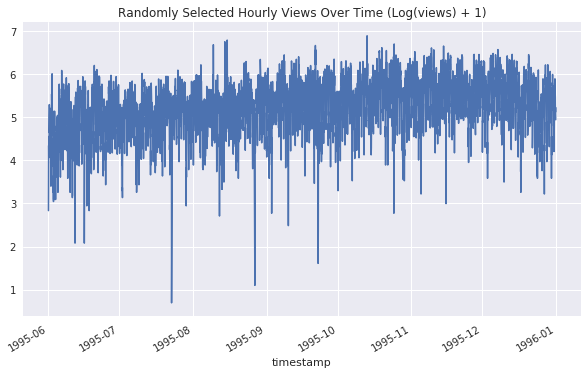

In [6]:
def plot_random_series(df, n_series):
    
    sample = df.sample(n_series, random_state=8)
    series_samples = sample.loc[:,data_start_date:data_end_date]
    
    plt.figure(figsize=(10,6))
    
    for i in range(series_samples.shape[0]):
        np.log1p(pd.Series(series_samples.iloc[i]).astype(np.float64)).plot(linewidth=1.5)
    
    plt.title('Randomly Selected Hourly Views Over Time (Log(views) + 1)')
    
plot_random_series(transpose_request_series, 1)

Formatting for training

In [155]:
from datetime import timedelta

pred_steps = 24
pred_length=timedelta(seconds = pred_steps*3600)

first_day = pd.to_datetime(data_start_date) 
last_day = pd.to_datetime(data_end_date)

val_pred_start = last_day - pred_length
val_pred_end = last_day

train_pred_start = val_pred_start - pred_length
train_pred_end = val_pred_start - timedelta(days=1)

In [156]:
enc_length = train_pred_start - first_day

train_enc_start = first_day
train_enc_end = train_enc_start + enc_length - timedelta(1)

val_enc_start = train_enc_start + pred_length
val_enc_end = val_enc_start + enc_length - timedelta(1)

In [157]:
print('Train encoding:', train_enc_start, '-', train_enc_end)
print('Train prediction:', train_pred_start, '-', train_pred_end, '\n')
print('Val encoding:', val_enc_start, '-', val_enc_end)
print('Val prediction:', val_pred_start, '-', val_pred_end)

print('\nEncoding interval:', enc_length.days)
print('Prediction interval:', pred_length.days)

Train encoding: 1995-06-01 01:00:00 - 1995-12-28 23:00:00
Train prediction: 1995-12-29 23:00:00 - 1995-12-29 23:00:00 

Val encoding: 1995-06-02 01:00:00 - 1995-12-29 23:00:00
Val prediction: 1995-12-30 23:00:00 - 1995-12-31 23:00:00

Encoding interval: 211
Prediction interval: 1


# Data Preparation

In [158]:
date_to_index = pd.Series(index=pd.Index([pd.to_datetime(c) for c in df.columns[1:]]),
                          data=[i for i in range(len(df.columns[1:]))])

series_array = df[df.columns[1:]].values



# Keras Data Formatting

In [159]:
date_to_index = df

In [160]:
df.values.shape

(5105, 1)

In [161]:
series_array = df.values

In [162]:
def get_time_block_series(series_array, date_to_index, start_date, end_date):
    
    inds = date_to_index[start_date:end_date]
    return series_array[inds].swapaxes(0,1)

def transform_series_encode(series_array):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_mean = series_array.mean(axis=1).reshape(-1,1) 
    series_array = series_array - series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array, series_mean

def transform_series_decode(series_array, encode_series_mean):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_array = series_array - encode_series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array

In [163]:
a = get_time_block_series(series_array,date_to_index,train_enc_start,train_enc_end)
a.shape

(1, 5032, 1)

In [164]:
b = get_time_block_series(series_array,date_to_index,val_enc_start,val_enc_end)
b.shape

(1, 5032, 1)

# Building the Model - Training Architecture

In [165]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense
from keras.optimizers import Adam

latent_dim = 50 # LSTM hidden units
dropout = .20 

# Define an input series and encode it with an LSTM. 
encoder_inputs = Input(shape=(None, 1)) 
encoder = LSTM(latent_dim, dropout=dropout, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the final states. These represent the "context"
# vector that we use as the basis for decoding.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
# This is where teacher forcing inputs are fed in.
decoder_inputs = Input(shape=(None, 1)) 

# We set up our decoder using `encoder_states` as initial state.  
# We return full output sequences and return internal states as well. 
# We don't use the return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, dropout=dropout, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)

decoder_dense = Dense(1) # 1 continuous output at each timestep
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [166]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, None, 1)      0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           (None, None, 1)      0                                            
__________________________________________________________________________________________________
lstm_5 (LSTM)                   [(None, 50), (None,  10400       input_9[0][0]                    
__________________________________________________________________________________________________
lstm_6 (LSTM)                   [(None, None, 50), ( 10400       input_10[0][0]                   
                                                                 lstm_5[0][1]                     
          

In [167]:
encoder_input_data = get_time_block_series(series_array, date_to_index, 
                                           train_enc_start, train_enc_end)

In [168]:
encoder_input_data

array([[[ 99],
        [184],
        [ 60],
        ...,
        [ 54],
        [113],
        [110]]])

In [169]:
batch_size = 2**3
epochs = 100

# sample of series from train_enc_start to train_enc_end  
encoder_input_data = get_time_block_series(series_array, date_to_index, 
                                           train_enc_start, train_enc_end)
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

# sample of series from train_pred_start to train_pred_end 
decoder_target_data = get_time_block_series(series_array, date_to_index, 
                                            train_pred_start, train_pred_end)
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)



In [170]:
# lagged target series for teacher forcing
decoder_input_data = np.zeros(decoder_target_data.shape)


In [171]:
decoder_input_data[:,1:,0] = decoder_target_data[:,:-1,0]


In [172]:
encoder_input_data

array([[[-0.2027018 ],
        [ 0.41248384],
        [-0.69699812],
        ...,
        [-0.8005388 ],
        [-0.07167354],
        [-0.09834178]]])

In [173]:
decoder_input_data

array([[[0.]]])

In [174]:
decoder_input_data[:,:,0]

array([[0.]])

In [175]:
encoder_input_data[:,:,0]

array([[-0.2027018 ,  0.41248384, -0.69699812, ..., -0.8005388 ,
        -0.07167354, -0.09834178]])

In [176]:
decoder_input_data[:,0,0] = encoder_input_data[:,-1,0]

In [177]:
model.compile(Adam(), loss='mean_absolute_error')
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
                     batch_size=batch_size,
                     epochs=epochs)

Epoch 1/100
1/1 [==============================] - 5s 5s/step - loss: 0.5436
Epoch 2/100
1/1 [==============================] - 4s 4s/step - loss: 0.5277
Epoch 3/100
1/1 [==============================] - 4s 4s/step - loss: 0.4918
Epoch 4/100
1/1 [==============================] - 4s 4s/step - loss: 0.4878
Epoch 5/100
1/1 [==============================] - 4s 4s/step - loss: 0.4822
Epoch 6/100
1/1 [==============================] - 4s 4s/step - loss: 0.4577
Epoch 7/100
1/1 [==============================] - 4s 4s/step - loss: 0.4421
Epoch 8/100
1/1 [==============================] - 4s 4s/step - loss: 0.4242
Epoch 9/100
1/1 [==============================] - 4s 4s/step - loss: 0.4038
Epoch 10/100
1/1 [==============================] - 4s 4s/step - loss: 0.4379
Epoch 11/100
1/1 [==============================] - 4s 4s/step - loss: 0.3590
Epoch 12/100
1/1 [==============================] - 4s 4s/step - loss: 0.3369
Epoch 13/100
1/1 [==============================] - 4s 4s/step - loss: 0.

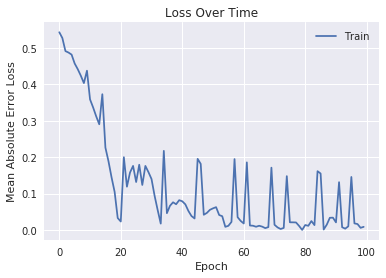

In [178]:
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

# Build Inference Model

In [179]:
# from our previous model - mapping encoder sequence to state vectors
encoder_model = Model(encoder_inputs, encoder_states)

# A modified version of the decoding stage that takes in predicted target inputs
# and encoded state vectors, returning predicted target outputs and decoder state vectors.
# We need to hang onto these state vectors to run the next step of the inference loop.
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]

decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs,
                      [decoder_outputs] + decoder_states)

def decode_sequence(input_seq):
    
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, 1))
    
    # Populate the first target sequence with end of encoding series pageviews
    target_seq[0, 0, 0] = input_seq[0, -1, 0]

    # Sampling loop for a batch of sequences - we will fill decoded_seq with predictions
    # (to simplify, here we assume a batch of size 1).

    decoded_seq = np.zeros((1,pred_steps,1))
    
    for i in range(pred_steps):
        
        output, h, c = decoder_model.predict([target_seq] + states_value)
        
        decoded_seq[0,i,0] = output[0,0,0]

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, 1))
        target_seq[0, 0, 0] = output[0,0,0]

        # Update states
        states_value = [h, c]

    return decoded_seq

In [180]:
encoder_input_data = get_time_block_series(series_array, date_to_index, val_enc_start, val_enc_end)
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

decoder_target_data = get_time_block_series(series_array, date_to_index, val_pred_start, val_pred_end)
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

In [227]:
def predict_and_plot(encoder_input_data, decoder_target_data, sample_ind, enc_tail_len=50):

    
    
    
    encode_series = encoder_input_data[sample_ind:sample_ind+1,:,:] 
    pred_series = decode_sequence(encode_series)
    
    encode_series = encode_series.reshape(-1,1)
    pred_series = pred_series.reshape(-1,1)   
    target_series = decoder_target_data[sample_ind,:,:1].reshape(-1,1) 
    
    target_series = target_series.flatten()

    encode_series = encode_series.flatten()
    print(pred_series)
    
    encode_series_tail = np.concatenate([encode_series[-enc_tail_len:],target_series[:1]])
    x_encode = encode_series_tail.shape[0]
    
    
    plt.figure(figsize=(10,6))   
    
    plt.plot(range(1,x_encode+1),np.exp(encode_series_tail))
    plt.plot(range(x_encode,x_encode+pred_steps),np.exp(target_series[:-1]),color='orange')
    plt.plot(range(x_encode,x_encode+pred_steps),np.exp(pred_series),color='teal',linestyle='--')
    
    plt.title('Encoder Series Tail of Length %d, Target Series, and Predictions' % enc_tail_len)
    plt.legend(['Encoding Series','Target Series','Predictions'])

[[0.3865231 ]
 [0.38413453]
 [0.38230279]
 [0.38121134]
 [0.38044554]
 [0.37974289]
 [0.37896279]
 [0.37805033]
 [0.37700412]
 [0.37585175]
 [0.37463278]
 [0.37338826]
 [0.37215492]
 [0.37096256]
 [0.36983341]
 [0.36878243]
 [0.36781821]
 [0.36694464]
 [0.3661615 ]
 [0.36546594]
 [0.36485299]
 [0.36431685]
 [0.36385062]
 [0.36344752]]


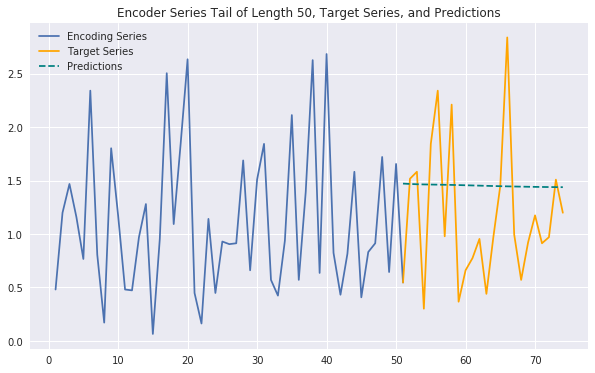

In [228]:
predict_and_plot(encoder_input_data, decoder_target_data, 0)